In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# A dictionary of the physical properties
phys_props = {
    'pa'  : 1e5,    # mean pressure
    'pb'  : 200.0,  # magnitude of pressure variation
    'f'   : 1e-4,   # Coriolis paramter
    'rho' : 1.0,    # density
    'L'   : 2.4e6,  # length scale of pressure variation
    'ymin': 0.0,    # start of y doamin
    'ymax': 1e6,    # end of y domain
}

# The numerical scheme used to evaluate the boundary terms in the 
# gradient_2point function. 
# Set this to either "2-point" or "3-point"
b_scheme = "3_point"

In [3]:
def pressure(y, props):
    """
    Calculates the pressure at a given y location

    Args:
        y:
            The location data at which pressure will be calculated
        props:
            The dictionary containing the physical properties 
            used in calculations

    Returns:
        pressure_calc:
            The calculated pressure at the given location

    Raises:
        TODO:
    """

    # Extract the physical properties from the input dict 
    pa = props["pa"]
    pb = props["pb"]
    L  = props["L"]

    # Calculate and return the pressure
    pressure_calc = pa + pb*np.cos(y*np.pi/L)
    return pressure_calc

def geo_exact(y, props):
    """
    Calculates the analytic geostrophic wind at a given y location

    Args:
        y:
            The location data at which wind will be calculated
        props:
            The dictionary containing the physical properties 
            used in calculations

    Returns:
        geo_calc:
            The exact, analytical wind speed at the given location

    Raises:
        TODO:
    """

    # Extract the physical properties from the input dict 
    pb  = props["pb"]
    L   = props["L"]
    rho = props["rho"]
    f   = props["f"]

    # Calculate and return wind speed
    geo_calc = pb*np.pi/(rho*f*L)*np.sin(y*np.pi/L)
    return geo_calc

def geo_numer(dpdy, props):
    """
    Calculates the numerical geostrophic wind speed as a function of 
    pressure gradient.

    Args:
        dpdy:
            Pressure gradient causing the geostrophic wind
        props:
            The dictionary containing the physical properties 
            used in calculations

    Returns:
        wind_calc: 
            The calculated wind speed for the given pressure gradient

    Raises:
        TODO:
    """

    # Extract the physical properties from the input dict 
    rho = props["rho"]
    f   = props["f"]

    # Calculate and return wind speed
    wind_calc = -dpdy/(rho*f)
    return wind_calc

In [4]:
def gradient_3point(f, x, dx, direction):
    """
    Calculates the gradient of a 1D array using uncentered, forward or backward
    3-point difference assuming all points are a distance dx apart.

    Used to ensure the end points maintain second order accuracy. 

    Args:
        f:
            1D input array
        x: 
            Index of f at which the difference is performed
        dx:
            Distance used in calculating 2-point difference
        direction:
            String which indicates the direction to calculate the 
            finite differences
                "forward" : Calculates f'(x) using f(x+1) and f(x+2)
                "backward": Calculates f'(x) using f(x-1) and f(x-2)

    Returns:
        dfdx:
            The gradient at the location specified using input args

    Raises:
        Exception: "direction arg must be either \"forward\" or \"backward\""
    """

    # Calculate the forward or backward 3-point difference
    # Found using Taylor series approximations for f(x) 
    if direction == "forward":
        dfdx = (-3*f[x] + 4*f[x+1] - f[x+2])/(2*dx)
    elif direction == "backward":
        dfdx = (+3*f[x] - 4*f[x-1] + f[x-2])/(2*dx)
    else:
        raise Exception("direction arg must be either \"forward\" or \"backward\"")

    return dfdx

def gradient_2point(f, dx, boundary_scheme="2-point"):
    """
    Calculates the gradient of a 1D array using 2-point difference
    on the inner points and a user-defined scheme for the end points 
    assuming all points are a distance dx apart

    Args:
        f:
            1D input array
        dx:
            Distance used in calculating numerical differences
        boundary_scheme:
            The numerical scheme used to calculate the end points
            Defaults to "2-point"
                "2-point": Boundaries calculated using 2 point
                           forward and backward scheme
                "3-point": Boundaries calculated using 3 point
                           forward and backward scheme

    Returns:
        dfdx:
            An array of gradients of the same size as the input array f 

    Raises:
        Exception: "boundary_scheme arg must be either \"2-point\" or \"3-point\""
    """

    # Initialise gradient array to be same size as f
    dfdx = np.zeros_like(f)

    # Calculates the boudnary terms using a user-chosen scheme
    if boundary_scheme == "2-point":
        # Perform 2-point forward and backward difference at the boundaries
        # which should only be first order accurate.
        dfdx[ 0] = (f[ 1] - f[ 0])/dx
        dfdx[-1] = (f[-1] - f[-2])/dx
    elif boundary_scheme == "3-point":
        # Perform forward and backward 3-point difference at the boundaries
        # to maintain second order accuracy throughout the scheme
        dfdx[ 0] = gradient_3point(f,  0, dx, "forward")
        dfdx[-1] = gradient_3point(f, -1, dx, "backward")
    else:
        raise Exception("boundary_scheme arg must be either \"2-point\" or \"3-point\"")

    # Perform 2-point centered difference at the inner grid points
    for i in range(1, len(f) - 1):
        dfdx[i] = (f[i+1] - f[i-1])/(2*dx)
    return dfdx

In [5]:
################## MTMW12 Assignment 3 ######################
## Python 3 code to numerically differentiate the pressure ##
## to calculate geostrophic wind relation using 2-point    ##
## difference and compare result with analytical solution  ##
#############################################################

def geostrophic_wind(ymin, ymax, N):
    """
    Calculates the geostrophic wind using analytical and 
    2-point difference numerical scheme

    Args:
        ymin:
            Start of the grid domain
        ymax:
            End of the grid domain
        N:
            Number of grid points to evaluate over

    Returns:
        u_exact:
            The array of wind speeds calculated using analytical method
        u_numerical:
            The array of wind speeds calculated using 2-point numerical method

    Raises: TODO
    """

    # Initialise grid resolution and domain
    dy = (ymax - ymin)/N                # Spacing between grid points
    y  = np.linspace(ymin, ymax, N+1)   # Grid of points

    # Calculate pressure and pressure gradient
    #############################################################
    ### User can change b_scheme to be "2-point" or "3-point" ###
    #############################################################
    p    = pressure(y, phys_props)
    dpdy = gradient_2point(p, dy, boundary_scheme=b_scheme)

    # Calculate the exact and numerical geotrophic wind solutions
    u_exact     = geo_exact(y, phys_props)
    u_numerical = geo_numer(dpdy, phys_props)

    return u_exact, u_numerical

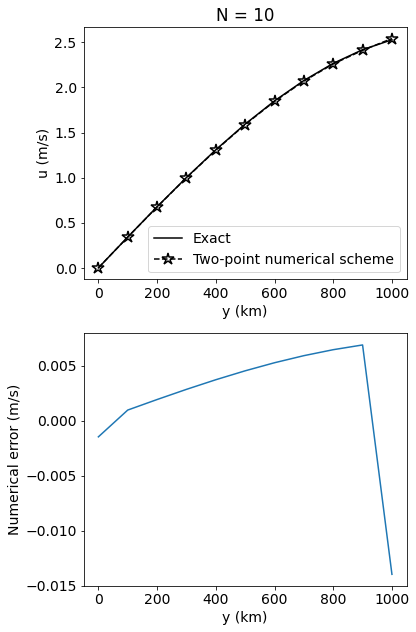

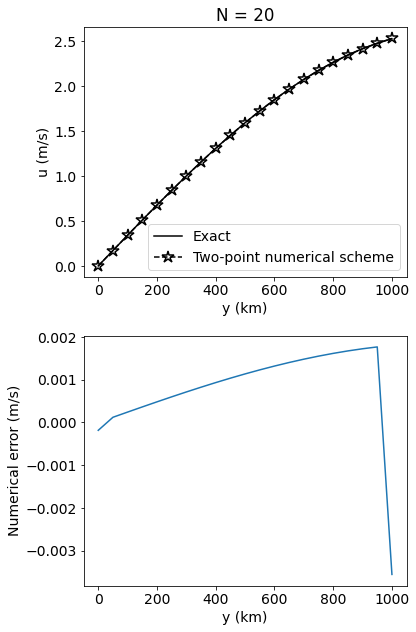

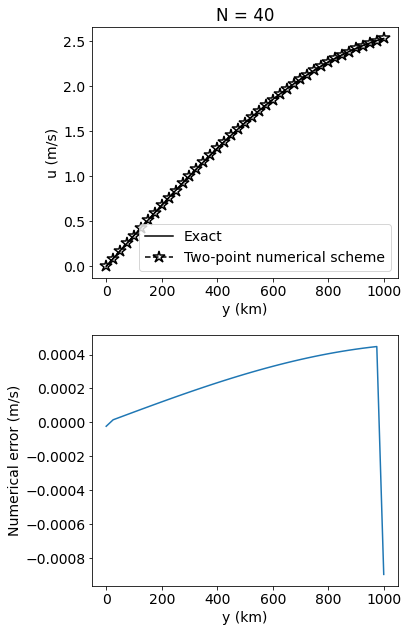

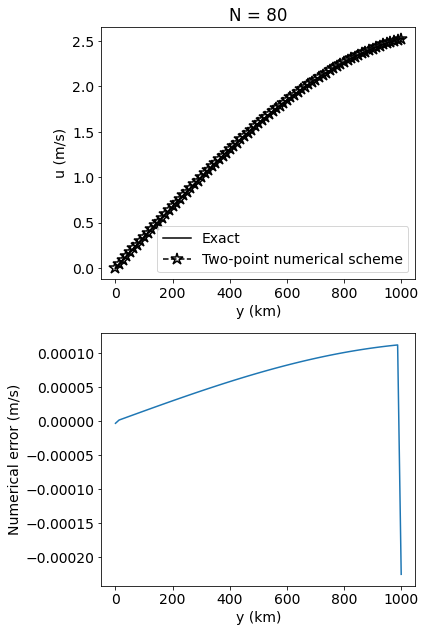

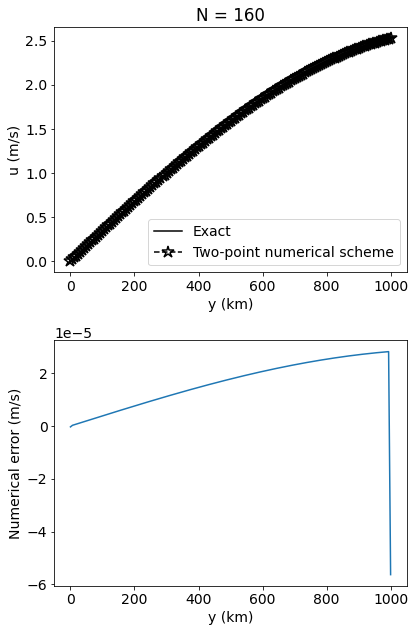

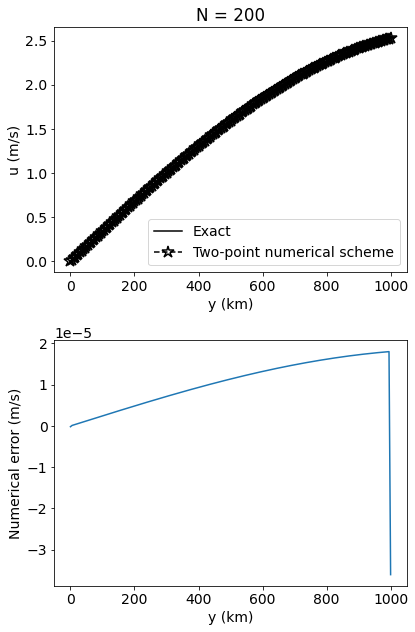

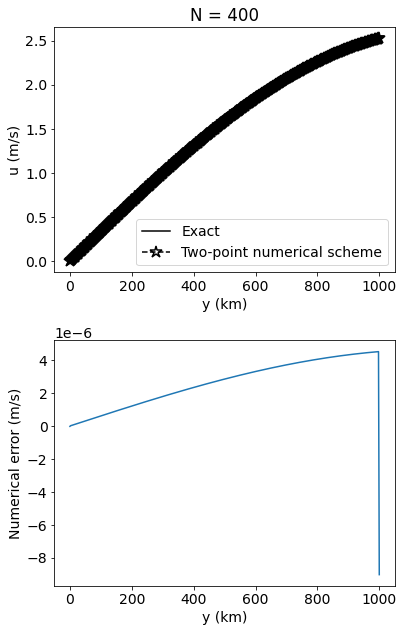

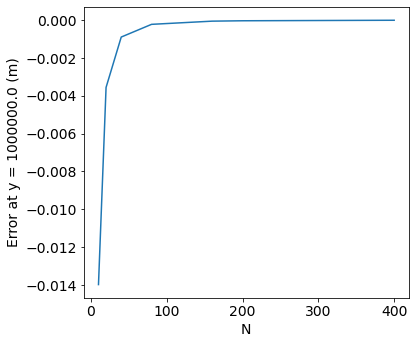

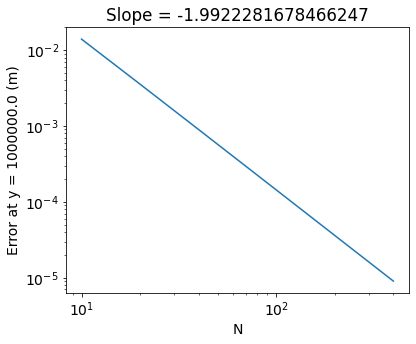

In [6]:
def main():
    #############
    ### Plots ###
    #############

    # Define graph properties
    font = {'size': 14}
    plt.rc('font', **font)
    plt.rcParams["figure.figsize"] = (6,9)
    scale = 1/1000

    # Get domain start and end
    ymin = phys_props['ymin']
    ymax = phys_props['ymax']

    # Array of N values to test
    N_array = [10, 20, 40, 80, 160, 200, 400]

    # Initialise error array
    #####################################################
    ### User can change the sample point to test the  ###
    ### accuracy at different locations of the domain ###
    #####################################################
    sample_point = 10e5  # The y location at which to evaulate error
    error_at_sample_point = []

    for N in N_array:
        # Calculate the wind speeds
        y = np.linspace(ymin, ymax, N+1) 
        exact_wind, numerical_wind = geostrophic_wind(ymin, ymax, N)

        # Calculate the errors between the exact and numerical solution
        error_array = exact_wind - numerical_wind

        # Get the error at a specific point, add to error_at_sample_point list
        sample_index = int(sample_point*N/ymax)       # The index of the sample point
        error_at_sample_point.append(error_array[sample_index])

        # Plot exact and numerical wind solutions
        fig, ax = plt.subplots(2)
        ax[0].plot(y*scale, exact_wind, 'k-', label='Exact')
        ax[0].plot(
            y*scale, 
            numerical_wind, 
            '*k--', 
            label='Two-point numerical scheme',
            ms=12,
            markeredgewidth=1.5,
            markerfacecolor='none',
        )
        ax[0].legend(loc='best')
        ax[0].set_title(f"N = {N}")
        ax[0].set_xlabel("y (km)")
        ax[0].set_ylabel("u (m/s)")
        
        # Plot the errors
        ax[1].plot(y*scale, error_array)   
        ax[1].set_xlabel("y (km)")
        ax[1].set_ylabel("Numerical error (m/s)")
        plt.tight_layout()
        plt.savefig(f"geo_n_{N}.png")
        plt.show()

    # Plot the error at the chosen location for each value of N
    # Linear plot
    plt.rcParams["figure.figsize"] = (6,5)
    plt.plot(N_array, error_at_sample_point)
    plt.xlabel("N")
    plt.ylabel(f"Error at y = {sample_point} (m)")
    plt.tight_layout()
    plt.savefig("error_linear.png")
    plt.show()

    # Perform linear regression to extract slope of log graph
    # Slope = order of accuracy of numerical scheme
    fit = stats.linregress(np.log(N_array), np.log(np.abs(error_at_sample_point)))
    slope = fit[0]

    # Plot the error at the chosen location for each value of N
    # Log plot, easier to see exponential relation
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(N_array, np.abs(error_at_sample_point))
    plt.xlabel("N")
    plt.ylabel(f"Error at y = {sample_point} (m)")
    plt.title(f"Slope = {slope}")
    plt.tight_layout()
    plt.savefig("error_log.png")
    plt.show()

main()